In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.visualization import make_lupton_rgb
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
#plt.style.use('dark_background')

from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc

plt.rcParams["pdf.fonttype"] = 42  # Ensures text is stored as a TrueType font
plt.rcParams["font.family"] = "serif"  # Use a common font


In [2]:
data_zoo = pd.read_csv('data/complete_data.csv')

filepath = '/Users/jimenagonzalez/research/DSPL/Citizen_science_project/Intersection/data/in_sled2.fits'
hdu_list = fits.open(filepath)
images = hdu_list[1].data
data = pd.DataFrame(hdu_list[2].data)
hdu_list.close()

data.replace('None', np.nan, inplace=True)
data = data.astype({'COADD_OBJECT_ID': int, 'K_RA': float, 'K_DEC': float, 'K_SCORE': float, 'Y3_COADD_OBJECT_ID': int,
       'J_RA': float, 'J_DEC': float, 'score_sims': float, 'score_real': float, 'score_both': float, 'G_RA': float,
       'G_DEC': float, 'SINGLE': float, 'RING': float, 'SMOOTH': float, 'COMPANIONS': float, 'SDSS_SPIRALS': float,
       'DES_SPIRALS': float, 'CROWDED': float, 'ARTIFACTS': float, 'MOST_NEGATIVES': float, 'index': int, 'ra': float,
       'dec': float, 'name': str, 'score': float, 'image_sep': float, 'info': str, 'n_img': float, 'flag': str,
       'image_conf': str, 'lens_type': str, 'source_type': str, 'contaminant_type': str, 'papers': str})

#Getting the images
data.set_index('COADD_OBJECT_ID', inplace=True)
data_zoo.set_index('COADD_OBJECT_ID', inplace=True)
# Reindex 'data' to match the index of 'data_zoo'
data = data.reindex(data_zoo.index)
# Reset index if needed
data.reset_index(inplace=True)
data_zoo.reset_index(inplace=True)
images = images[data.index]

#New calibrated score:
usernames = ['Krojas26', 'sgonzalezloz', 'curiosorus', 'ctortora', 'clarkguilty', 'alejandramelo', 'anupreeta']
scores_only = data_zoo[usernames]

def remove_min_max(row):
    valid_scores = row.dropna().tolist()
    if len(valid_scores) <= 2:
        # Not enough values to remove min and max
        return pd.Series([None] * max(0, len(valid_scores) - 2))
    trimmed = sorted(valid_scores)[1:-1]  # Remove lowest and highest
    return pd.Series(trimmed, index=[f'user{i+1}' for i in range(len(trimmed))])

data_zoo_tmp = data_zoo[usernames].apply(remove_min_max, axis=1)
data_zoo_tmp = pd.concat([data_zoo.drop(columns=usernames), data_zoo_tmp], axis=1)

new_usernames = ['user1', 'user2', 'user3', 'user4', 'user5']
data_zoo_tmp['calib'] = data_zoo_tmp[new_usernames].mean(axis=1)
#data_zoo_tmp['calib_std'] = data_zoo_tmp[new_usernames].std(axis=1)
#data_zoo_tmp['calib_range'] = data_zoo_tmp[new_usernames].max(axis=1) - data_zoo_tmp[new_usernames].min(axis=1)

data_zoo = data_zoo_tmp
data_zoo = data_zoo.drop(['average'], axis=1)
data_zoo = data_zoo.rename({'calib': 'average'}, axis=1)

In [3]:
#Table for SLED inspected sample

#Opening csv file with name of paper and survey
unique_refs = pd.read_csv('data/unique_refs.csv')

refs_citations = pd.read_csv('data/unique_refs_citation.csv')
unique_refs = unique_refs.merge(refs_citations[['papers', 'Name', 'Survey', 'My ref']], on='papers')
unique_refs['Number_cand'] = [0]*len(unique_refs)

for i in range(len(data_zoo)):
    papers = data_zoo['papers'].iloc[i].split(', ')
    for ref in papers:
        unique_refs.loc[unique_refs['papers'] == ref, 'Number_cand'] += 1
        
unique_refs = unique_refs.sort_values(by=['Survey', 'Number_cand'], ascending=[True, False])

print('Number of references from inspected sample: ', len(unique_refs))

table_paper = pd.DataFrame(columns=['Reference', 'Survey', 'Number Candidates'])

rows = []
for i in range(len(unique_refs)):
    tmp_list = ['a'] * 3
    tmp_list[0] = '\cite{' + unique_refs['My ref'].iloc[i] + '}'
    tmp_list[0] = tmp_list[0].replace('&', '').replace('"', '')
    tmp_list[1] = unique_refs['Survey'].iloc[i]
    tmp_list[2] = str(unique_refs['Number_cand'].iloc[i]) + '\\\\'
    rows.append({'Reference': tmp_list[0], 'Survey': tmp_list[1], 'Number Candidates': tmp_list[2]})

table_paper = pd.DataFrame(rows)

table_paper.to_csv('Figures/SLED_sample.csv', index=False)
table_paper.to_csv('Figures/SLED_sample_latex.csv', index=False, sep='&')

Number of references from inspected sample:  42


1651


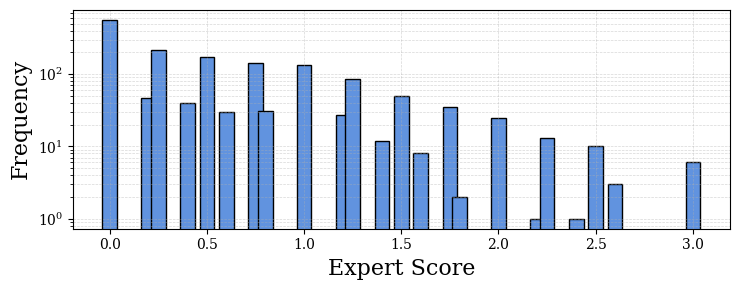

In [4]:
#Figure 3, plotting all unique values, distribution expert scores
print(len(data_zoo))

counts = data_zoo['average'].value_counts().sort_index()
plt.figure(figsize=(7.5, 3))
plt.bar(counts.index, counts.values, width=0.075, color='#6193DF', edgecolor='black')
plt.yscale('log')
plt.xlabel('Expert Score', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
#plt.title('Histogram of Expert Score Averages (Fixed Bin Width)')
plt.grid(True, which='both', linestyle='--', alpha=0.5, linewidth=0.5)
plt.tight_layout()
plt.savefig('Figures/exp_scores_histogram.pdf', format="pdf", dpi=300, bbox_inches="tight")
plt.show()


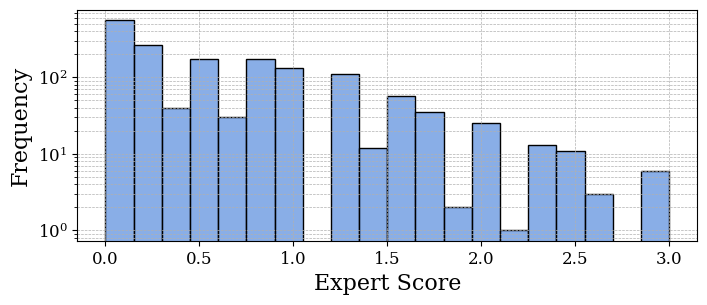

In [5]:
# Previous Figure 3, distribution of expert scores

fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlabel('Expert Score', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, linestyle='--', linewidth=0.5)
plt.yscale('log')
sns.histplot(data_zoo['average'], bins=20, ax=ax, color='#6193DF', edgecolor='black') #kde=True
#plt.savefig('Figures/exp_scores_histogram.pdf', format="pdf", dpi=300, bbox_inches="tight")
plt.show()

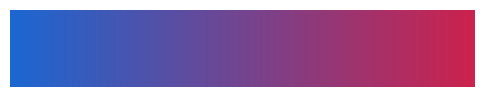

In [6]:
# Define the custom colormap from white to #2d8dff
colors = ["#000000", "#2d8dff"]
colors = ["#1b67d2", "#cc224d"]

custom_cmap = LinearSegmentedColormap.from_list("custom_blue", colors, N=256)

# Test the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)

fig, ax = plt.subplots(figsize=(6, 1))
ax.imshow(gradient, aspect="auto", cmap=custom_cmap)
ax.set_axis_off()
plt.show()

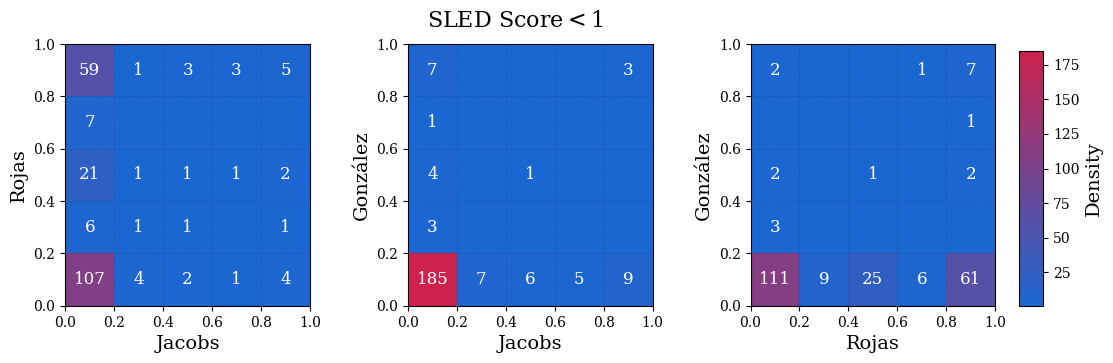

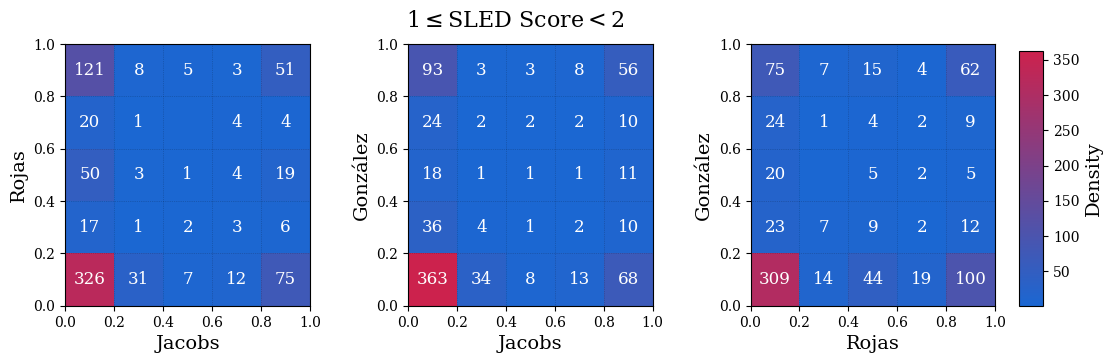

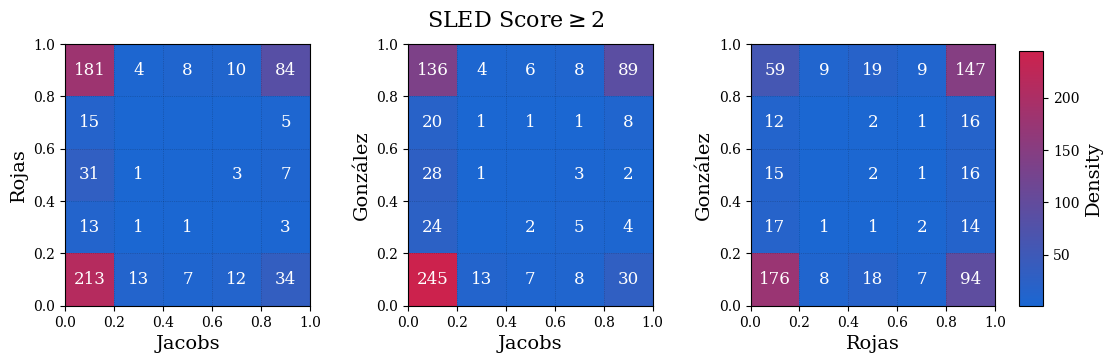

In [7]:
#Figure 2, with SLED scores, showing why we had to do the visual inspection

score_threshold = [0, 1, 2, 3.1]
ml_pairs = [['score_sims', 'K_SCORE'], ['score_sims', 'SINGLE'], ['K_SCORE', 'SINGLE']]
title_plot = {'score_sims': 'Jacobs', 'K_SCORE': 'Rojas', 'SINGLE': 'González'}
titles_text = ['SLED Score'+r'$<$'+'1', '1'+r'$\leq$'+'SLED Score'+r'$<$'+'2', 'SLED Score'+r'$\geq$'+'2']

for j in range(3):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.4), gridspec_kw={'wspace': 0.4})
    data_tmp = data_zoo[(data_zoo['score'] >= score_threshold[j]) & 
                        (data_zoo['score'] < score_threshold[j+1])]
    
    max_count = float('-inf')
    histograms = []  # Store histogram outputs

    # Compute histograms once
    for i in range(3):
        ml1, ml2 = ml_pairs[i]
        h, xedges, yedges, im = axs[i].hist2d(data_tmp[ml1], data_tmp[ml2], bins=5, cmap=custom_cmap)
        max_count = max(max_count, h.max())
        histograms.append((h, xedges, yedges))  # Store for reuse

    # Plot subfigures and place bin counts as text
    for i, (h, xedges, yedges) in enumerate(histograms):
        
        ml1, ml2 = ml_pairs[i]
        axs[i].set_xlabel(title_plot[ml1], fontsize=14)
        axs[i].set_ylabel(title_plot[ml2], fontsize=14)

        # Reuse histogram with updated vmax
        im = axs[i].hist2d(data_tmp[ml1], data_tmp[ml2], bins=5, cmap=custom_cmap, vmin=1, vmax=max_count)[-1]

        axs[i].set_xticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
        axs[i].set_yticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
        
        # Add bin count text
        for xi in range(len(xedges) - 1):
            for yi in range(len(yedges) - 1):
                count = h[xi, yi]
                if count > 0:
                    axs[i].text((xedges[xi] + xedges[xi+1]) / 2, 
                                (yedges[yi] + yedges[yi+1]) / 2, 
                                int(count), color='white', ha='center', va='center', fontsize=12)

        # Add faint grid lines for bins
        for x in xedges:
            axs[i].axvline(x, color='black', linestyle='dotted', alpha=0.3, linewidth=0.5)
        for y in yedges:
            axs[i].axhline(y, color='black', linestyle='dotted', alpha=0.3, linewidth=0.5)

        # Spearman correlation (optional)
        correlation, _ = spearmanr(data_tmp[ml1], data_tmp[ml2])
        #axs[i].set_title(f"ρ = {correlation:.2f}", fontsize=12)

    # Create colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.75])
    cbar = fig.colorbar(im, cax=cbar_ax, label='Density')
    cbar.ax.yaxis.label.set_size(14)

    plt.suptitle(titles_text[j], fontsize=16, y=0.98)
    #plt.tight_layout(rect=[0, 0, 0.9, 1])
    #plt.savefig(f'Figures/2d_histo_sled_{score_threshold[j]}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'Figures/2d_histo_sled_{score_threshold[j]}.pdf', format="pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
filepath = '/Users/jimenagonzalez/research/DSPL/Citizen_science_project/Intersection/'
data_inter = pd.read_csv(filepath + 'intersection.csv')
data_inter = data_inter.dropna()  # Remove rows with NaN values
data_inter = data_inter.replace([np.inf, -np.inf], np.nan).dropna()


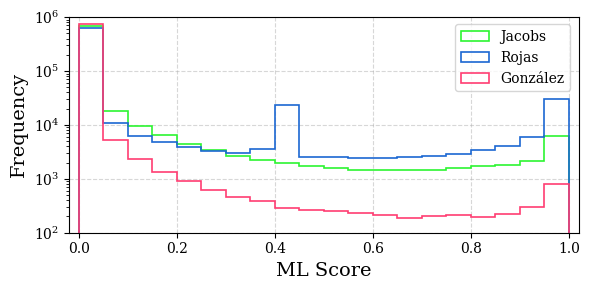

In [9]:
#Distribution ML scores

ml_model = ['score_sims', 'K_SCORE', 'SINGLE']
title_plot = ['Jacobs', 'Rojas', 'González']
color_plot = ['#2cf531', '#1b67d2', '#ff3d72']

all_data = np.concatenate([data_zoo['SINGLE'], data_zoo['K_SCORE'], data_zoo['score_sims']])
bin_edges = np.histogram_bin_edges(data_zoo['SINGLE'], bins= 20)#'auto')

plt.figure(figsize=(6, 3))

for i in range(3):
    plt.xlabel('ML Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.hist(data_inter[ml_model[i]], bins=bin_edges, histtype='step', alpha=1, edgecolor=color_plot[i], 
             linewidth=1.2, label=title_plot[i])
    plt.grid(True, which='major', linestyle='--', alpha=0.5)
    plt.yscale('log')
    plt.ylim(10**2, 10**6)
    plt.xlim(-0.02, 1.02)
    plt.tight_layout()

plt.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.87, 1))
plt.savefig('Figures/Histo_ML_scores.pdf', format="pdf", dpi=300, bbox_inches="tight")
plt.show()

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


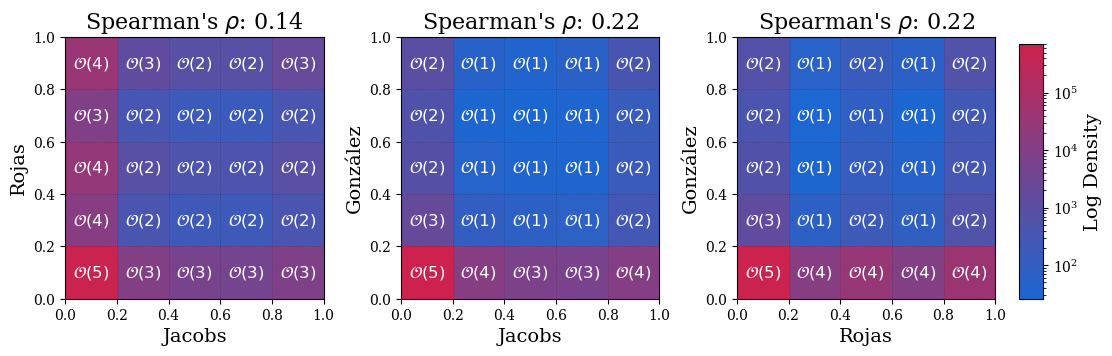

In [10]:
#Figure 4, is there a correlation between the different ML score sets?
import math

ml_pairs = [['score_sims', 'K_SCORE'], ['score_sims', 'SINGLE'], ['K_SCORE', 'SINGLE']]
title_plot = {'score_sims': 'Jacobs', 'K_SCORE': 'Rojas', 'SINGLE': 'González'}
#titles_text = ['SLED Score < 1', '1 < SLED Score < 2', 'SLED Score > 2']


fig, axs = plt.subplots(1, 3, figsize=(12, 3.4), gridspec_kw={'wspace': 0.3})

max_count = float('-inf')
min_count = float('inf')
histograms = []  # Store histogram outputs

# Compute histograms once
for i in range(3):
    ml1, ml2 = ml_pairs[i]
    h, xedges, yedges, im = axs[i].hist2d(data_inter[ml1], data_inter[ml2], bins=5, cmap=custom_cmap)
    max_count = max(max_count, h.max())
    min_count = min(min_count, h.min())
    histograms.append((h, xedges, yedges))  # Store for reuse

# Plot subfigures and place bin counts as text
for i, (h, xedges, yedges) in enumerate(histograms):
        
    ml1, ml2 = ml_pairs[i]
    axs[i].set_xlabel(title_plot[ml1], fontsize=14)
    axs[i].set_ylabel(title_plot[ml2], fontsize=14)

    # Reuse histogram with updated vmax
    im = axs[i].hist2d(data_inter[ml1], data_inter[ml2], bins=5, cmap=custom_cmap, 
                    vmin=min_count, vmax=max_count, norm=LogNorm(vmin=min_count, vmax=max_count))[-1] 
    
    axs[i].set_xticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
    axs[i].set_yticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
        
    # Add bin count text
    for xi in range(len(xedges) - 1):
        for yi in range(len(yedges) - 1):
            count = h[xi, yi]
            if count > 0:
                order_of_magnitude = math.floor(math.log10(abs(count))) if count != 0 else 0
                formatted_number = f"$\\mathcal{{O}}({order_of_magnitude})$"
                count_string = formatted_number
                
                axs[i].text((xedges[xi] + xedges[xi+1]) / 2, 
                                (yedges[yi] + yedges[yi+1]) / 2, 
                                count_string, color='white', ha='center', va='center', fontsize=12)

    # Add faint grid lines for bins
    for x in xedges:
        axs[i].axvline(x, color='black', linestyle='dotted', alpha=0.3, linewidth=0.5)
    for y in yedges:
        axs[i].axhline(y, color='black', linestyle='dotted', alpha=0.3, linewidth=0.5)

    # Spearman correlation (optional)
    correlation, _ = spearmanr(data_inter[ml1], data_inter[ml2])
    axs[i].set_title(r"Spearman's $\rho$: {:.2f}".format(correlation), fontsize=16)

# Create colorbar
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, label='Log Density')
cbar.ax.yaxis.label.set_size(14)

#plt.savefig('Figures/2d_histo_correlation_mls.png', dpi=300, bbox_inches='tight')

plt.savefig('Figures/2d_histo_correlation_mls.pdf', format="pdf", dpi=300, bbox_inches="tight")
plt.show()


/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


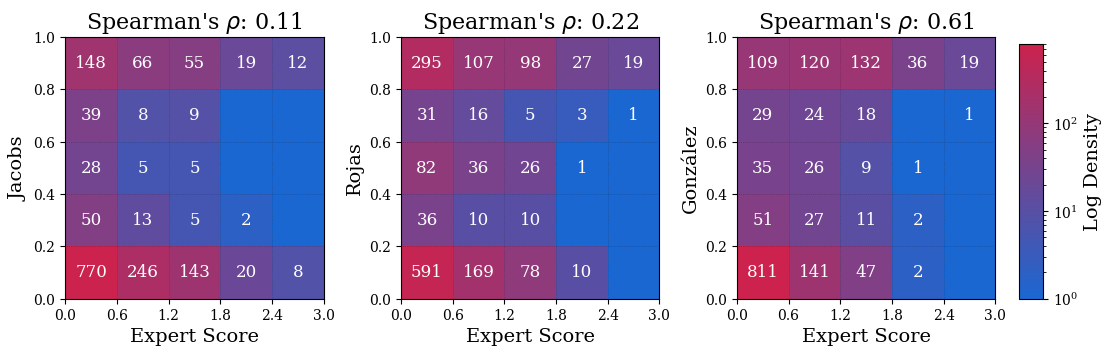

In [11]:
#Figure 5, correlation ML models - experts
import math

ml_pairs = [['average', 'score_sims'], ['average', 'K_SCORE'], ['average', 'SINGLE']]
title_plot = {'average': 'Expert Score', 'score_sims': 'Jacobs', 'K_SCORE': 'Rojas', 'SINGLE': 'González'}

fig, axs = plt.subplots(1, 3, figsize=(12, 3.4), gridspec_kw={'wspace': 0.3})

max_count = float('-inf')
min_count = float('inf')
histograms = []  # Store histogram outputs

# Compute histograms once
for i in range(3):
    ml1, ml2 = ml_pairs[i]
    h, xedges, yedges, im = axs[i].hist2d(data_zoo[ml1], data_zoo[ml2], bins=5, cmap=custom_cmap)
    max_count = max(max_count, h.max())
    min_count = min(min_count, h.min())
    histograms.append((h, xedges, yedges))  # Store for reuse

min_count = 1

# Plot subfigures and place bin counts as text
for i, (h, xedges, yedges) in enumerate(histograms):
        
    ml1, ml2 = ml_pairs[i]
    axs[i].set_xlabel(title_plot[ml1], fontsize=14)
    axs[i].set_ylabel(title_plot[ml2], fontsize=14)

    # Reuse histogram with updated vmax
    im = axs[i].hist2d(data_zoo[ml1], data_zoo[ml2], bins=5, cmap=custom_cmap, 
                    vmin=min_count, vmax=max_count, norm=LogNorm(vmin=min_count, vmax=max_count))[-1] 
    
    axs[i].set_xticks(np.linspace(0, 3, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
    axs[i].set_yticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
        
    # Add bin count text
    for xi in range(len(xedges) - 1):
        for yi in range(len(yedges) - 1):
            count = h[xi, yi]
            if count > 0:
                order_of_magnitude = math.floor(math.log10(abs(count))) if count != 0 else 0
                formatted_number = f"$\\mathcal{{O}}({order_of_magnitude})$"
                count_string = formatted_number
                
                axs[i].text((xedges[xi] + xedges[xi+1]) / 2, 
                                (yedges[yi] + yedges[yi+1]) / 2, 
                                int(count), color='white', ha='center', va='center', fontsize=12)

    # Add faint grid lines for bins
    for x in xedges:
        axs[i].axvline(x, color='black', linestyle='dotted', alpha=0.3, linewidth=0.5)
    for y in yedges:
        axs[i].axhline(y, color='black', linestyle='dotted', alpha=0.3, linewidth=0.5)

    # Spearman correlation (optional)
    correlation, _ = spearmanr(data_zoo[ml1], data_zoo[ml2])
    axs[i].set_title(r"Spearman's $\rho$: {:.2f}".format(correlation), fontsize=16)

# Create colorbar
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax, label='Log Density')
cbar.ax.yaxis.label.set_size(14)

plt.savefig('Figures/2d_histo_ml_exp.pdf', format="pdf", dpi=300, bbox_inches="tight")
plt.show()



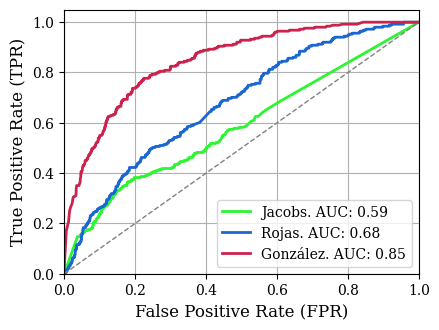

In [12]:
#Performance: ROC curves, together
score_threshold = [1.2]#[1.8, 1.2, 0.8]
ml_model = ['score_sims', 'K_SCORE', 'SINGLE']
title_plot = ['Jacobs', 'Rojas', 'González']
color_plot = ['#2cf531', '#1b67d2', '#cc224d']

plt.figure(figsize=(12,3.7))
for j in range(len(score_threshold)):
    y_true = data_zoo['average'] > score_threshold[j]
    plt.subplot(1, 3, j + 1)
    for i in range(3):
        fpr, tpr, thresholds = roc_curve(y_true, data_zoo[ml_model[i]])
        roc_auc = auc(fpr, tpr)
        label = title_plot[i] + '. AUC: {:.2f}'.format(roc_auc)
        plt.plot(fpr, tpr, lw=2, label=label, color=color_plot[i], alpha=1)
        #plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    text = 'ROC Curve - Exp. Score > ' + str(score_threshold[j])
    #plt.title(text, fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True)
    #plt.suptitle('Expert score > ' + str(score_threshold[j]), fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.savefig('Figures/ROC_curve_1.75.png', dpi=300, bbox_inches='tight')
    plt.savefig('Figures/ROC_curve_1.2.pdf', format="pdf", dpi=300, bbox_inches="tight")
plt.show()

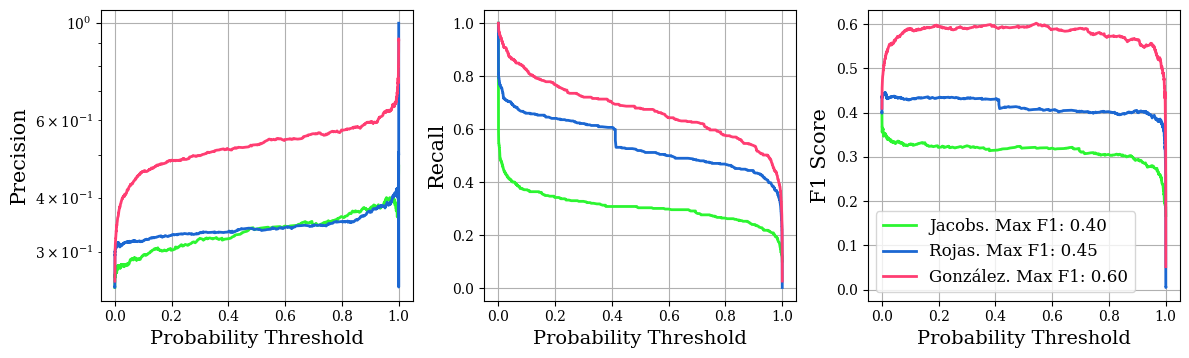

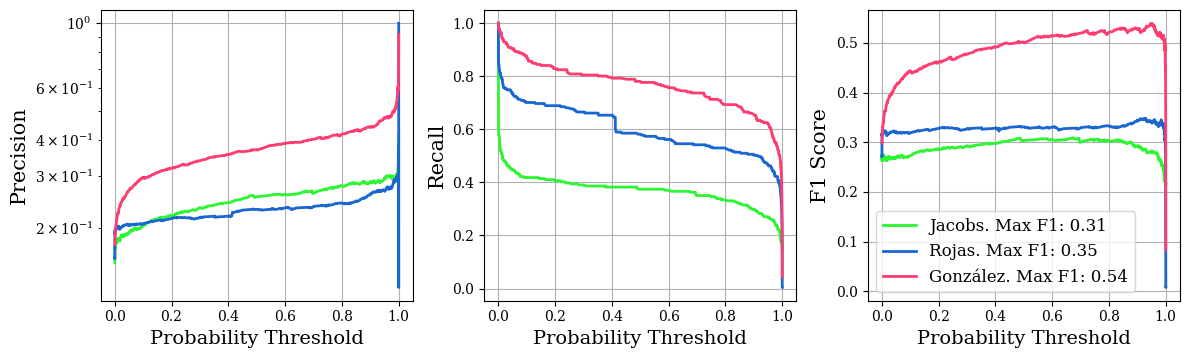

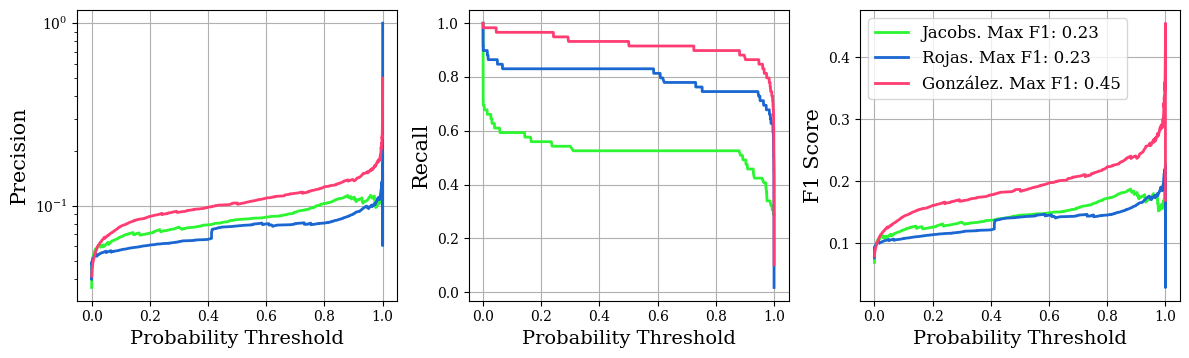

In [13]:
#Recall, precision & F1-score, each row other exp score
score_threshold = [0.8, 1.2, 1.8] #[1.8, 1.2, 0.8]
ml_model = ['score_sims', 'K_SCORE', 'SINGLE']
title_plot = ['Jacobs', 'Rojas', 'González']
color_plot = ['#2cf531', '#1b67d2', '#ff3d72']
perf_met_names = ['Precision', 'Recall', 'F1 Score']

# Loop over each threshold
for j in range(3):
    y_true = data_zoo['average'] > score_threshold[j]  # Binary labels based on threshold
    plt.figure(figsize=(12, 4))
    
    # Loop over each model
    for i in range(3):
        y_scores = data_zoo[ml_model[i]]
        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
        perf_met = {'Precision': precision, 'Recall': recall, 'thresholds': thresholds}
        pr_auc = auc(recall, precision)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
        perf_met['F1 Score'] = f1_scores
        
        for k in range(3):
            plt.subplot(1, 3, k + 1)
            data_tmp = perf_met[perf_met_names[k]]
            label_text = title_plot[i] + '. Max F1: {:.2f}'.format(max(f1_scores))
            plt.plot(thresholds, data_tmp[:-1], label=label_text, lw=2, color = color_plot[i], alpha=1)
            plt.xlabel('Probability Threshold', fontsize=14)
            plt.ylabel(perf_met_names[k], fontsize=15)
            if(perf_met_names[k] == 'Precision'): plt.yscale('log')
            if(k==2):
                plt.legend(fontsize=12)#(loc='upper center')
            plt.grid(True)
            
            
    #plt.suptitle('Expert score > ' + str(score_threshold[j]), fontsize=14, y=0.94)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
    plt.savefig('Figures/Perf_curves_'+str(score_threshold[j]) + '.pdf', format="pdf", dpi=300, bbox_inches="tight")
    plt.show()

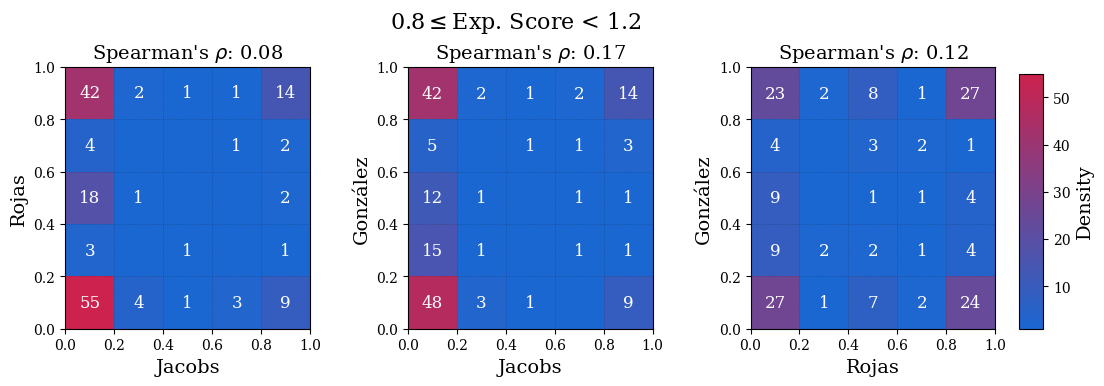

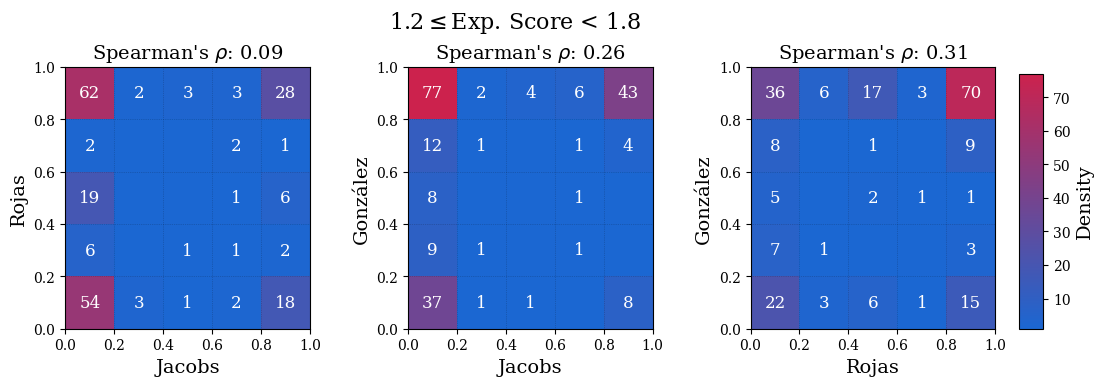

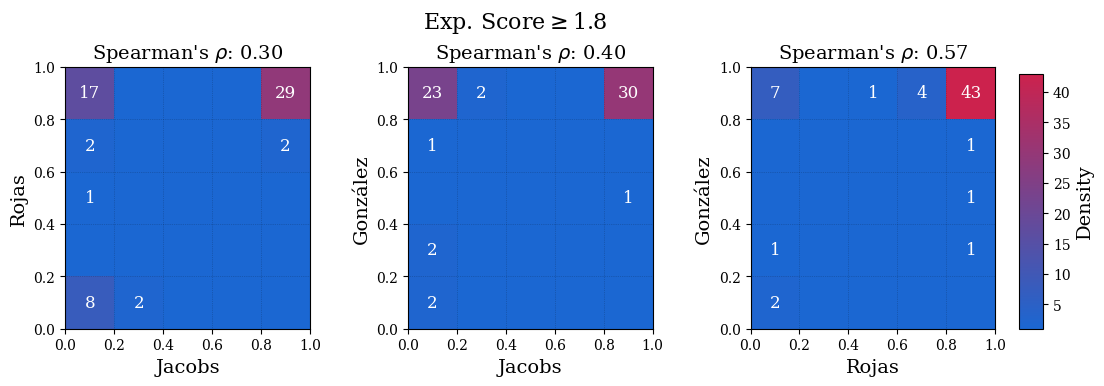

In [14]:
#Figure 8, most important figure: ML works :)

score_threshold = [0.8, 1.2, 1.8, 3.1] #[1.8, 1.2, 0.8]
ml_pairs = [['score_sims', 'K_SCORE'], ['score_sims', 'SINGLE'], ['K_SCORE', 'SINGLE']]
title_plot = {'score_sims': 'Jacobs', 'K_SCORE': 'Rojas', 'SINGLE': 'González'}
titles_text = ['0.8'+r'$\leq$'+'Exp. Score < 1.2', '1.2'+r'$\leq$'+'Exp. Score < 1.8', 'Exp. Score'+r'$\geq$'+'1.8']

for j in range(3):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.4), gridspec_kw={'wspace': 0.4})
    data_tmp = data_zoo[(data_zoo['average'] >= score_threshold[j]) & 
                        (data_zoo['average'] < score_threshold[j+1])]
    
    max_count = float('-inf')
    histograms = []  # Store histogram outputs

    # Compute histograms once
    for i in range(3):
        ml1, ml2 = ml_pairs[i]
        h, xedges, yedges, im = axs[i].hist2d(data_tmp[ml1], data_tmp[ml2], bins=5, cmap=custom_cmap)
        max_count = max(max_count, h.max())
        histograms.append((h, xedges, yedges))  # Store for reuse

    # Plot subfigures and place bin counts as text
    for i, (h, xedges, yedges) in enumerate(histograms):
        
        ml1, ml2 = ml_pairs[i]
        axs[i].set_xlabel(title_plot[ml1], fontsize=14)
        axs[i].set_ylabel(title_plot[ml2], fontsize=14)

        # Reuse histogram with updated vmax
        im = axs[i].hist2d(data_tmp[ml1], data_tmp[ml2], bins=5, cmap=custom_cmap, vmin=1, vmax=max_count)[-1]

        axs[i].set_xticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
        axs[i].set_yticks(np.linspace(0, 1, 6))  # 6 ticks: [0, 0.2, 0.4, 0.6, 0.8, 1]
        
        # Add bin count text
        for xi in range(len(xedges) - 1):
            for yi in range(len(yedges) - 1):
                count = h[xi, yi]
                if count > 0:
                    axs[i].text((xedges[xi] + xedges[xi+1]) / 2, 
                                (yedges[yi] + yedges[yi+1]) / 2, 
                                int(count), color='white', ha='center', va='center', fontsize=12)

        # Add faint grid lines for bins
        for x in xedges:
            axs[i].axvline(x, color='black', linestyle='dotted', alpha=0.3, linewidth=0.5)
        for y in yedges:
            axs[i].axhline(y, color='black', linestyle='dotted', alpha=0.3, linewidth=0.5)

        # Spearman correlation (optional)
        correlation, _ = spearmanr(data_tmp[ml1], data_tmp[ml2])
        axs[i].set_title(r"Spearman's $\rho$: {:.2f}".format(correlation), fontsize=14)

    # Create colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.75])
    cbar = fig.colorbar(im, cax=cbar_ax, label='Density')
    cbar.ax.yaxis.label.set_size(14)

    plt.suptitle(titles_text[j], fontsize=16, y=1.05)
    #plt.tight_layout(rect=[0, 0, 0.9, 1])
    #plt.savefig(f'Figures/2d_histo_{score_threshold[j]}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'Figures/2d_histo_{score_threshold[j]}.pdf', format="pdf", dpi=300, bbox_inches="tight")
    plt.show()

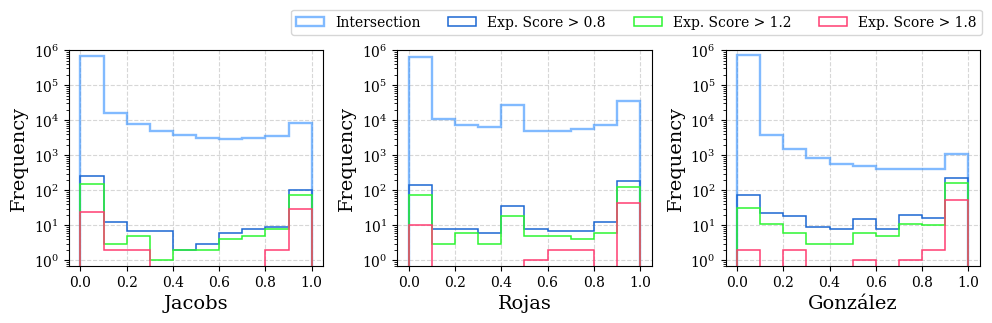

In [15]:
#Figure 9, distribution each ML scores: exp. scores & including intersection

score_threshold = [0.8, 1.2, 1.8] #[1.8, 1.2, 0.8]
ml_model = ['score_sims', 'K_SCORE', 'SINGLE']
title_plot = ['Jacobs', 'Rojas', 'González']
color_plot = ['#1b67d2', '#2cf531', '#ff3d72']

all_data = np.concatenate([data_zoo['SINGLE'], data_zoo['K_SCORE'], data_zoo['score_sims']])
#bin_edges = np.histogram_bin_edges(all_data, bins='auto')
bin_edges = np.histogram_bin_edges(data_zoo['SINGLE'], bins= 10)#'auto')

plt.figure(figsize=(10, 3))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlabel(title_plot[i], fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.hist(data_inter[ml_model[i]], bins=bin_edges, label='Intersection', histtype='step', 
             alpha=0.6, edgecolor='#2d8dff', linewidth=1.7)
    for j in range(3):
        data_tmp = data_zoo[data_zoo['average'] > score_threshold[j]]
        label_text = 'Exp. Score > ' + str(score_threshold[j])
        plt.hist(data_tmp[ml_model[i]], bins=bin_edges, alpha=1., label=label_text, histtype='step',
                 edgecolor=color_plot[j], linewidth=1.1)
    plt.grid(True, which='major', linestyle='--', alpha=0.5)
    plt.yscale('log')
    plt.ylim(0.7, 10**6)
    plt.tight_layout()

#plt.legend(fontsize=10)
plt.legend(loc='upper center', bbox_to_anchor=(-0.35, 1.22), ncol=4)
plt.savefig('Figures/histo_good_cand.pdf', format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
def make_plot_all(objects, title, data, column_name):
    #print(title)
    for i in range(len(objects)):
        if(i%8 == 0):
            plt.figure(figsize=(16,9))
            for j in range(8):
                if(i+j > len(objects)-1): break
                plt.subplot(1,8,j+1)
                #print(data['COADD_OBJECT_ID'].iloc[i+j])
                new_title = 'Exp. Score: {:.1f}'.format(data[column_name].iloc[i+j])
                plt.title(new_title, fontsize=13)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                rgb = np.flipud(rgb)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            #plt.savefig('Figures/' + title + '.png', bbox_inches='tight')
            plt.savefig('Figures/' + title + '.pdf', format="pdf", dpi=300, bbox_inches="tight")
            plt.show()

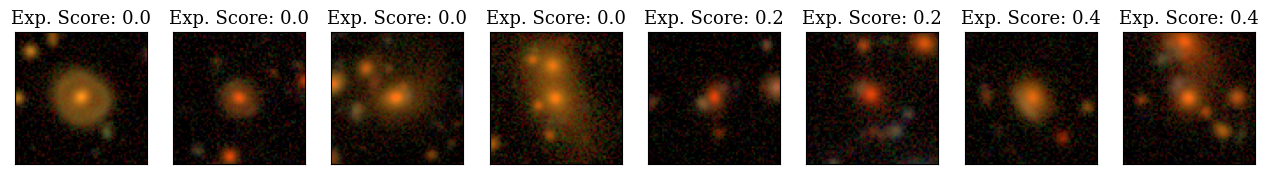

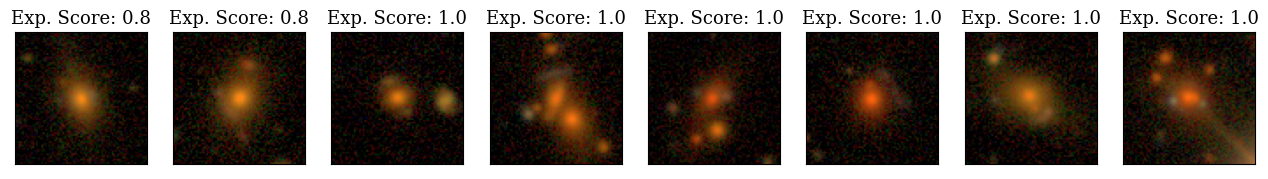

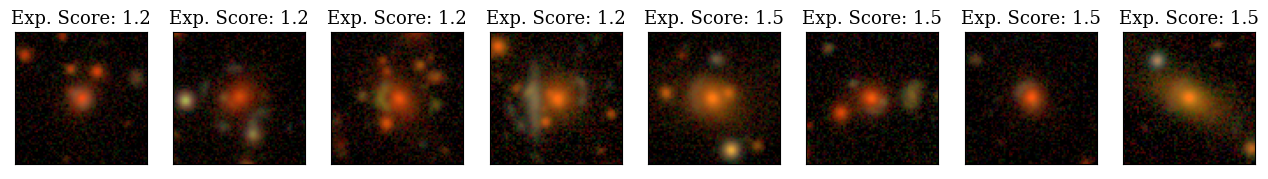

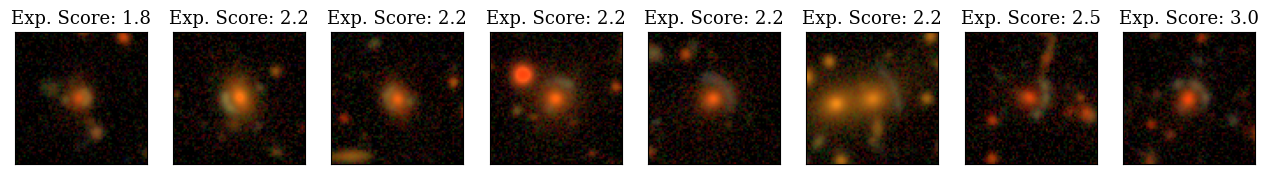

In [17]:
threshold_list = [0.8, 1.2, 1.8]

#Z class
data_zoo_tmp = data_zoo[data_zoo['average'] < threshold_list[0]]
data_zoo_tmp = data_zoo_tmp.sample(8, random_state=14)
data_zoo_tmp = data_zoo_tmp.sort_values(by='average', axis=0)
images_tmp = images[data_zoo_tmp.index]
make_plot_all(images_tmp, 'Z_class', data_zoo_tmp, 'average')

#C class
data_zoo_tmp = data_zoo[(data_zoo['average'] >= threshold_list[0]) & (data_zoo['average'] < threshold_list[1])]
data_zoo_tmp = data_zoo_tmp.sample(8, random_state=14)
data_zoo_tmp = data_zoo_tmp.sort_values(by='average', axis=0)
images_tmp = images[data_zoo_tmp.index]
make_plot_all(images_tmp, 'C_class', data_zoo_tmp, 'average')

#B class
data_zoo_tmp = data_zoo[(data_zoo['average'] >= threshold_list[1]) & (data_zoo['average'] < threshold_list[2])]
data_zoo_tmp = data_zoo_tmp.sample(8, random_state=14)
data_zoo_tmp = data_zoo_tmp.sort_values(by='average', axis=0)
images_tmp = images[data_zoo_tmp.index]
make_plot_all(images_tmp, 'B_class', data_zoo_tmp, 'average')

#A class
data_zoo_tmp = data_zoo[data_zoo['average'] >= threshold_list[2]]
data_zoo_tmp = data_zoo_tmp.sample(8, random_state=14)
data_zoo_tmp = data_zoo_tmp.sort_values(by='average', axis=0)
images_tmp = images[data_zoo_tmp.index]

make_plot_all(images_tmp, 'A_class', data_zoo_tmp, 'average')